<a href="https://colab.research.google.com/github/dvignoles/nyc-transpo/blob/master/nyc_transpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
from datetime import datetime
import numpy as np
import requests, zipfile, io, os, re, csv
import matplotlib.pyplot as plt

TAXI_CSV_PATH = "./taxi_data"
BIKE_CSV_PATH = "./bike_data"

# We will use with 2013-2018 June data since June 2013 is when Citi Bike was started, and 2013-2018 data is available for both taxi and bikes.
# We will also filter down to the first week of the month, because the data is an absolute unit
YEARS = ["2013", "2014", "2015", "2016", "2017", "2018"]

In [7]:
# Set up directories and util functions to store the downloaded csv files

if os.path.isdir(TAXI_CSV_PATH) is False:
  os.mkdir(TAXI_CSV_PATH)
if os.path.isdir(BIKE_CSV_PATH) is False:
  os.mkdir(BIKE_CSV_PATH)

  
def save_csv(file_path, http_data):
    with open(file_path, "w") as f:
      writer = csv.writer(f)
      reader = csv.reader(http_data.text.splitlines())
      for row in reader:
        writer.writerow(row)
        
def get_csv_name(data_type, year, two_weeks_only=False):
  if data_type is "taxi":
    return TAXI_CSV_PATH + "/" + year + "-06" + ("_parsed" if two_weeks_only is True else "") +  ".csv"
  elif data_type is "bike":
    return BIKE_CSV_PATH + "/" + year + "-06" + ("_parsed" if two_weeks_only is True else "") + ".csv"
  else:
    raise Exception("Data type must be taxi or bike")

# Taxi Dataframes
Since these downloads take a long time, do NOT reset all run times when it asks you to! It will wipe all downloaded files, and you'll have to download them again!

In [19]:
# Download and save the files first so they don't have to be redownloaded every time

for n in YEARS:
  file_path = get_csv_name("taxi", n, False)
  if os.path.isfile(file_path) is False:
    data = requests.get("https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_" + n + "-06.csv")
    save_csv(file_path, data)

# Load the actual data

dtypes = {
    "vendor_id": "str",
    "VendorID": "str",
    "pickup_datetime": "str",
    "dropoff_datetime": "str",
    "tpep_pickup_datetime": "str",
    "tpep_dropoff_datetime": "str",
    "passenger_count": np.int32,
    "trip_distance": np.float32,
    "pickup_longitude": np.float32,
    "pickup_latitude": np.float32,
    "PULocationID": np.int32,
    "DOLocationID": np.int32,
    "rate_code": np.int32,
    "RateCodeID": np.int32,
    "store_and_fwd_flag": "str",
    "dropoff_longitude": np.float32,
    "dropoff_latitude": np.float32,
    "payment_type": "str",
    "fare_amount": np.float32,
    "surcharge": np.float32,
    "mta_tax": np.float32,
    "tip_amount": np.float32,
    "tolls_amount": np.float32,
    "total_amount": np.float32
}

def get_parsed_taxi_df(year):
  # See if the sorted data was saved before, if so use it
  sorted_file_path = get_csv_name("taxi", year, True)
  if os.path.isfile(sorted_file_path) is True:
    df_toreturn = pd.read_csv(sorted_file_path, dtype=dtypes)
    df_toreturn['pickup_datetime_parsed'] = pd.to_datetime(df_toreturn['pickup_datetime_parsed'])
    return df_toreturn
  
  # Otherwise, load the full file, sort it, and save it for future reference
  df_temp = pd.read_csv(get_csv_name("taxi", year, False), dtype=dtypes)
  
  # Sort by date
  df_temp.sort_values(by=df_temp.columns[1], inplace=True, kind='mergesort')
  df_temp['pickup_datetime_parsed'] = pd.to_datetime(df_temp.iloc[:,1])
  
  # Get only the first week of the month
  df_temp = df_temp[(df_temp['pickup_datetime_parsed'] > (year + '-06-01')) & (df_temp['pickup_datetime_parsed'] < (year + '-06-08'))]
  df_temp.to_csv(sorted_file_path)
  return df_temp
  
# The util function MUST be used to save memory while loading in the entire dataframes for each year.
# IGNORE MEMORY LIMIT WARNINGS! The data is garbage collected every time the function exits for each year.

df_taxi_2013 = get_parsed_taxi_df("2013")
df_taxi_2014 = get_parsed_taxi_df("2014")
df_taxi_2015 = get_parsed_taxi_df("2015")
df_taxi_2016 = get_parsed_taxi_df("2016")
df_taxi_2017 = get_parsed_taxi_df("2017")
df_taxi_2018 = get_parsed_taxi_df("2018")

In [20]:
# convert pickup and dropoff to datetime object
# then add trip duration column
# standardize pickup/dropoff column names.

if not('tripduration' in df_taxi_2013.columns):
    df_taxi_2013['pickup_datetime'] = pd.to_datetime(df_taxi_2013['pickup_datetime'])
    df_taxi_2013['dropoff_datetime'] = pd.to_datetime(df_taxi_2013['dropoff_datetime'])
    df_taxi_2013['tripduration'] = (df_taxi_2013['dropoff_datetime'] - df_taxi_2013['pickup_datetime']).dt.total_seconds()

if not('tripduration' in df_taxi_2014.columns):
    df_taxi_2014['pickup_datetime'] = pd.to_datetime(df_taxi_2014[' pickup_datetime'])
    df_taxi_2014['dropoff_datetime'] = pd.to_datetime(df_taxi_2014[' dropoff_datetime'])
    df_taxi_2014['tripduration'] = (df_taxi_2014['dropoff_datetime'] - df_taxi_2014['pickup_datetime']).dt.total_seconds()
    df_taxi_2014 = df_taxi_2014.drop(columns=[' pickup_datetime', ' dropoff_datetime'])

if not('tripduration' in df_taxi_2015.columns):
    df_taxi_2015['pickup_datetime'] = pd.to_datetime(df_taxi_2015['tpep_pickup_datetime'])
    df_taxi_2015['dropoff_datetime'] = pd.to_datetime(df_taxi_2015['tpep_dropoff_datetime'])
    df_taxi_2015['tripduration'] = (df_taxi_2015['dropoff_datetime'] - df_taxi_2015['pickup_datetime']).dt.total_seconds()
    df_taxi_2015 = df_taxi_2015.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

if not('tripduration' in df_taxi_2016.columns):
    df_taxi_2016['pickup_datetime'] = pd.to_datetime(df_taxi_2016['tpep_pickup_datetime'])
    df_taxi_2016['dropoff_datetime'] = pd.to_datetime(df_taxi_2016['tpep_dropoff_datetime'])
    df_taxi_2016['tripduration'] = (df_taxi_2016['dropoff_datetime'] - df_taxi_2016['pickup_datetime']).dt.total_seconds()
    df_taxi_2016 = df_taxi_2016.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

if not('tripduration' in df_taxi_2017.columns):
    df_taxi_2017['pickup_datetime'] = pd.to_datetime(df_taxi_2017['tpep_pickup_datetime'])
    df_taxi_2017['dropoff_datetime'] = pd.to_datetime(df_taxi_2017['tpep_dropoff_datetime'])
    df_taxi_2017['tripduration'] = (df_taxi_2017['dropoff_datetime'] - df_taxi_2017['pickup_datetime']).dt.total_seconds()
    df_taxi_2017 = df_taxi_2017.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

if not('tripduration' in df_taxi_2018.columns):
    df_taxi_2018['pickup_datetime'] = pd.to_datetime(df_taxi_2018['tpep_pickup_datetime'])
    df_taxi_2018['dropoff_datetime'] = pd.to_datetime(df_taxi_2018['tpep_dropoff_datetime'])
    df_taxi_2018['tripduration'] = (df_taxi_2018['dropoff_datetime'] - df_taxi_2018['pickup_datetime']).dt.total_seconds()
    df_taxi_2018 = df_taxi_2018.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [21]:
# removes leading whitespace from df_taxi_2014 column names
for col_name in df_taxi_2014.columns:
    if col_name[0] == ' ':
        new_col_name = col_name[1:]
        df_taxi_2014[new_col_name] = df_taxi_2014[col_name]
        df_taxi_2014 = df_taxi_2014.drop([col_name], axis=1)

In [22]:
df_taxi_2013.head()

,Unnamed: 0,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_datetime_parsed,tripduration
0,10098349,CMT,2013-06-01 00:00:01,2013-06-01 00:04:45,1,1.7,-73.977707,40.746326,1,N,...,40.767628,CRD,7.0,0.5,0.5,1.6,0.0,9.6,2013-06-01 00:00:01,284.0
1,10098350,CMT,2013-06-01 00:00:01,2013-06-01 00:04:17,1,0.6,-73.983345,40.730515,1,N,...,40.737656,CRD,5.0,0.5,0.5,1.2,0.0,7.2,2013-06-01 00:00:01,256.0
2,10099007,CMT,2013-06-01 00:00:01,2013-06-01 00:07:54,1,1.2,-73.991638,40.744011,1,N,...,40.740738,CRD,7.0,0.5,0.5,1.6,0.0,9.6,2013-06-01 00:00:01,473.0
3,10097262,CMT,2013-06-01 00:00:02,2013-06-01 00:11:35,1,3.6,-73.970993,40.761608,1,N,...,40.760826,CRD,12.5,0.5,0.5,2.5,0.0,16.0,2013-06-01 00:00:02,693.0
4,10097622,CMT,2013-06-01 00:00:02,2013-06-01 00:12:57,2,3.6,-73.985451,40.763191,1,N,...,40.802811,CRD,11.5,0.5,0.5,2.5,0.0,15.0,2013-06-01 00:00:02,775.0


# Citi Bike Dataframes
Since Citi Bike does not directly provide csv files, we must handle the zip files, extract, and load them accordingly.

In [23]:
reg_pattern = re.compile("^\d+.*\.csv$")

for n in YEARS:
  # See if the file exists
  file_path = get_csv_name("bike", n)
  if os.path.isfile(file_path) is True:
    continue

  # If not, request and save it
  req_url = ""
  if n != "2017" and n != "2018":
    req_url = "https://s3.amazonaws.com/tripdata/" + n + "06-citibike-tripdata.zip"
  else:
    req_url = "https://s3.amazonaws.com/tripdata/" + n + "06-citibike-tripdata.csv.zip"
    
  # Handle the ZIP
  z = zipfile.ZipFile(io.BytesIO(requests.get(req_url).content))
  orig_file_name = list(filter(reg_pattern.match, z.namelist()))[0]
  z.extract(orig_file_name)
  os.rename(orig_file_name, get_csv_name("bike", n)) # Renaming the file will automatically remove the original, extracted file

In [24]:
# The dtypes can't be passed in atm because some columns that should be integers have non-number strings in them
# Some columns that should be integers are floats instead because pandas can't put NaN values in integer columns
"""
dtypes = {
    "tripduration": np.int32,
    "starttime": "str",
    "stoptime": "str",
    "start station id": np.float32,
    "start station name": "str",
    "start station latitude": np.float32,
    "start station longitude": np.float32,
    "end station id": np.float32,
    "end station name": "str",
    "end station latitude": np.float32,
    "end station longitude": np.float32,
    "bikeid": np.int32,
    "usertype": "str",
    "birth year": np.float32,
    "gender": np.int32
}
"""


df_bike_2013_orig = pd.read_csv(get_csv_name("bike", "2013"))
df_bike_2014_orig = pd.read_csv(get_csv_name("bike", "2014"))
df_bike_2015_orig = pd.read_csv(get_csv_name("bike", "2015"))
df_bike_2016_orig = pd.read_csv(get_csv_name("bike", "2016"))
df_bike_2017_orig = pd.read_csv(get_csv_name("bike", "2017"))
df_bike_2018_orig = pd.read_csv(get_csv_name("bike", "2018"))

In [25]:
# Convert to datetime. This was really annoying with the different formats - if the format is unspecified, the functions never stop running.
# Also must assert that the last row of data has a start time greater than the second week, to make sure we have the full first 2 weeks of data

# 2013
df_bike_2013_orig['starttime_parsed'] = pd.to_datetime(df_bike_2013_orig['starttime'])
df_bike_2013_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2013_orig['stoptime'])
assert df_bike_2013_orig.iloc[-1].starttime_parsed > datetime.strptime('2013-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2013"

# 2014
df_bike_2014_orig['starttime_parsed'] = pd.to_datetime(df_bike_2014_orig['starttime'])
df_bike_2014_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2014_orig['stoptime'])
assert df_bike_2014_orig.iloc[-1].starttime_parsed > datetime.strptime('2014-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2014"

# 2015
df_bike_2015_orig['starttime_parsed'] = pd.to_datetime(df_bike_2015_orig["starttime"], format="%m/%d/%Y %H:%M")
df_bike_2015_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2015_orig['stoptime'], format="%m/%d/%Y %H:%M")
assert df_bike_2015_orig.iloc[-1].starttime_parsed > datetime.strptime('2015-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2015"

# 2016
df_bike_2016_orig['starttime_parsed'] = pd.to_datetime(df_bike_2016_orig['starttime'], format="%m/%d/%Y %H:%M:%S")
df_bike_2016_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2016_orig['stoptime'], format="%m/%d/%Y %H:%M:%S")
assert df_bike_2016_orig.iloc[-1].starttime_parsed > datetime.strptime('2016-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2016"

# 2017
df_bike_2017_orig['starttime_parsed'] = pd.to_datetime(df_bike_2017_orig['starttime'], format="%Y-%m-%d %H:%M:%S")
df_bike_2017_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2017_orig['stoptime'], format="%Y-%m-%d %H:%M:%S")
assert df_bike_2017_orig.iloc[-1].starttime_parsed > datetime.strptime('2017-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2017"

# 2018
df_bike_2018_orig['starttime_parsed'] = pd.to_datetime(df_bike_2018_orig['starttime'], format="%Y-%m-%d %H:%M:%S")
df_bike_2018_orig['stoptime_parsed'] = pd.to_datetime(df_bike_2018_orig['stoptime'], format="%Y-%m-%d %H:%M:%S")
assert df_bike_2018_orig.iloc[-1].starttime_parsed > datetime.strptime('2018-06-07', '%Y-%m-%d'), "Missing full 1 week of data for 2018"

In [26]:
# Our main Citi Bike dataframes we'll be using, with a full week of data for each year

df_bike_2013 = df_bike_2013_orig[(df_bike_2013_orig['starttime_parsed'] > '2013-06-01') & (df_bike_2013_orig['starttime_parsed'] < '2013-06-08')]
df_bike_2014 = df_bike_2014_orig[(df_bike_2014_orig['starttime_parsed'] > '2014-06-01') & (df_bike_2014_orig['starttime_parsed'] < '2014-06-08')]
df_bike_2015 = df_bike_2015_orig[(df_bike_2015_orig['starttime_parsed'] > '2015-06-01') & (df_bike_2015_orig['starttime_parsed'] < '2015-06-08')]
df_bike_2016 = df_bike_2016_orig[(df_bike_2016_orig['starttime_parsed'] > '2016-06-01') & (df_bike_2016_orig['starttime_parsed'] < '2016-06-08')]
df_bike_2017 = df_bike_2017_orig[(df_bike_2017_orig['starttime_parsed'] > '2017-06-01') & (df_bike_2017_orig['starttime_parsed'] < '2017-06-08')]
df_bike_2018 = df_bike_2018_orig[(df_bike_2018_orig['starttime_parsed'] > '2018-06-01') & (df_bike_2018_orig['starttime_parsed'] < '2018-06-08')]


In [28]:
# add trip distance (distance between start and end station, in miles) to bike dataframes
# throws a bunch of errors, but idk still works so......

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) * .62137


df_bike_2013['trip_distance'] = haversine(
            df_bike_2013['start station latitude'], 
            df_bike_2013['start station longitude'],
            df_bike_2013['end station latitude'], 
            df_bike_2013['end station longitude'])

df_bike_2014['trip_distance'] = haversine(
            df_bike_2014['start station latitude'], 
            df_bike_2014['start station longitude'],
            df_bike_2014['end station latitude'], 
            df_bike_2014['end station longitude'])

df_bike_2015['trip_distance'] = haversine(
            df_bike_2015['start station latitude'], 
            df_bike_2015['start station longitude'],
            df_bike_2015['end station latitude'], 
            df_bike_2015['end station longitude'])

df_bike_2016['trip_distance'] = haversine(
            df_bike_2016['start station latitude'], 
            df_bike_2016['start station longitude'],
            df_bike_2016['end station latitude'], 
            df_bike_2016['end station longitude'])

df_bike_2017['trip_distance'] = haversine(
            df_bike_2017['start station latitude'], 
            df_bike_2017['start station longitude'],
            df_bike_2017['end station latitude'], 
            df_bike_2017['end station longitude'])

df_bike_2018['trip_distance'] = haversine(
            df_bike_2018['start station latitude'], 
            df_bike_2018['start station longitude'],
            df_bike_2018['end station latitude'], 
            df_bike_2018['end station longitude'])


/Users/Carl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arcsin
/Users/Carl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Carl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Carl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [29]:
df_bike_2018.head(20)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,starttime_parsed,stoptime_parsed,trip_distance
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1,2018-06-01 01:57:20.514,2018-06-01 02:06:50.088,0.670309
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1,2018-06-01 02:02:42.398,2018-06-01 02:10:43.354,0.778097
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1,2018-06-01 02:04:23.624,2018-06-01 02:15:55.747,0.640655
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1,2018-06-01 03:00:55.461,2018-06-01 03:11:59.906,1.257624
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1,2018-06-01 06:04:54.427,2018-06-01 06:18:32.617,1.592243
5,753,2018-06-01 06:11:52.5990,2018-06-01 06:24:26.1980,72,W 52 St & 11 Ave,40.767272,-73.993929,446,W 24 St & 7 Ave,40.744876,-73.995299,27073,Subscriber,1981,1,2018-06-01 06:11:52.599,2018-06-01 06:24:26.198,1.549059
6,687,2018-06-01 07:15:15.5650,2018-06-01 07:26:42.8670,72,W 52 St & 11 Ave,40.767272,-73.993929,212,W 16 St & The High Line,40.743349,-74.006818,14612,Subscriber,1968,1,2018-06-01 07:15:15.565,2018-06-01 07:26:42.867,1.785255
7,619,2018-06-01 07:40:02.5780,2018-06-01 07:50:22.0280,72,W 52 St & 11 Ave,40.767272,-73.993929,458,11 Ave & W 27 St,40.751396,-74.005226,16415,Subscriber,1990,2,2018-06-01 07:40:02.578,2018-06-01 07:50:22.028,1.246125
8,819,2018-06-01 07:43:01.9580,2018-06-01 07:56:41.3280,72,W 52 St & 11 Ave,40.767272,-73.993929,212,W 16 St & The High Line,40.743349,-74.006818,31551,Subscriber,1981,1,2018-06-01 07:43:01.958,2018-06-01 07:56:41.328,1.785255
9,335,2018-06-01 07:49:47.9340,2018-06-01 07:55:23.3090,72,W 52 St & 11 Ave,40.767272,-73.993929,514,12 Ave & W 40 St,40.760875,-74.002777,26058,Subscriber,1988,2,2018-06-01 07:49:47.934,2018-06-01 07:55:23.309,0.640117


# Analysis

## Exploratory Data Analysis

### Trip Distance

In [47]:
# df_taxi_2015 contains some weirdly high trip distance outliers.

df_taxi_2015[df_taxi_2015.trip_distance > 500].count()

Unnamed: 0                23
VendorID                  23
passenger_count           23
trip_distance             23
pickup_longitude          23
pickup_latitude           23
RateCodeID                23
store_and_fwd_flag        23
dropoff_longitude         23
dropoff_latitude          23
payment_type              23
fare_amount               23
extra                     23
mta_tax                   23
tip_amount                23
tolls_amount              23
improvement_surcharge     23
total_amount              23
pickup_datetime_parsed    23
pickup_datetime           23
dropoff_datetime          23
tripduration              23
dtype: int64

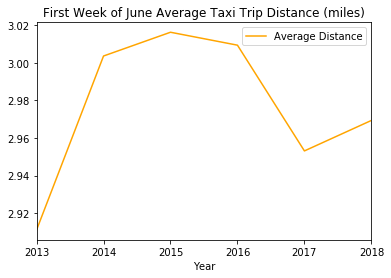

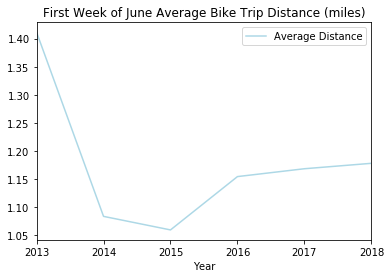

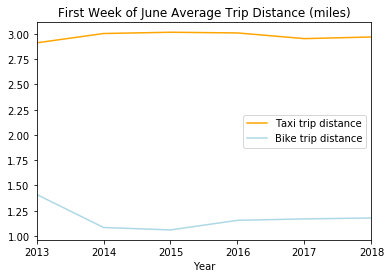

In [48]:
avg_trip_distance_bike = pd.DataFrame(
    {'Year': YEARS,
     'Average Distance': [
         df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()
     ]})

avg_trip_distance_taxi = pd.DataFrame(
    {'Year': YEARS,
     'Average Distance': [
         df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()
     ]})

avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Taxi Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Bike Trip Distance (miles)', color='lightblue')

_ = avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', ax=_, color='lightblue')
_.legend(['Taxi trip distance', 'Bike trip distance'])

### Trip Duration

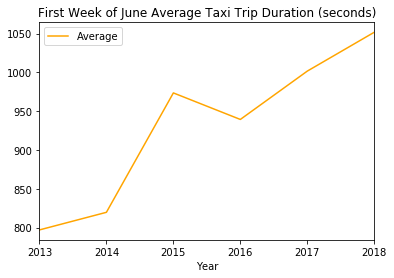

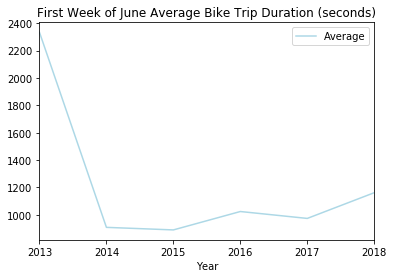

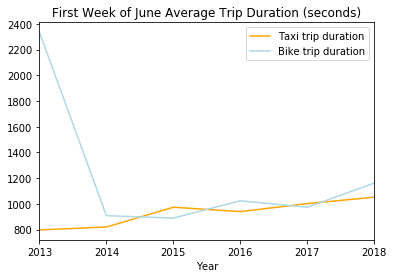

In [49]:
# Create average trip duration dataframes and plot

avg_trip_duration_bike = pd.DataFrame(
    {'Year': YEARS, 
     'Average': [
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] 
    })

avg_trip_duration_taxi = pd.DataFrame(
    {'Year': YEARS,
     'Average': [
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]
    })

avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Taxi Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Bike Trip Duration (seconds)', color='lightblue')

_ = avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', ax=_, color='lightblue')
_.legend(['Taxi trip duration', 'Bike trip duration'])

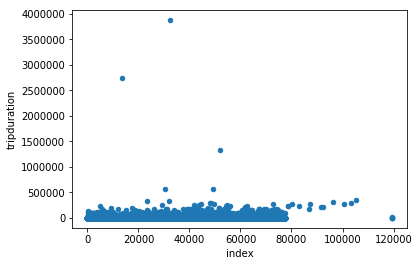

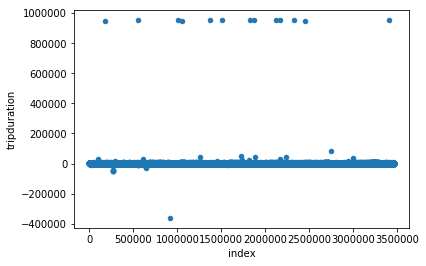

In [50]:
# quick scatter plot--exposes some weird outliers.  
# CitiBike has some >1000 hour trips
# Cabs have some negative time durations

df_bike_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

df_taxi_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

### CitiBike rider age

In [51]:
# had to avoid 2014 here, as there are some issues with the birthdate field in that dataframe. Will clean.
# yo people in their 40s love citibikes

citi_avg_age = []

citi_avg_age.append(df_bike_2013["birth year"].mean())
citi_avg_age.append("NaN")
citi_avg_age.append(df_bike_2015["birth year"].mean())
citi_avg_age.append(df_bike_2016["birth year"].mean())
citi_avg_age.append(df_bike_2017["birth year"].mean())
citi_avg_age.append(df_bike_2018["birth year"].mean())

print(citi_avg_age)

[1973.7418080639952, 'NaN', 1976.2964147385587, 1977.4734717561873, 1978.7014382409977, 1978.7112451471332]


### Number of Trips

In [52]:
# Using .loc everywhere here to try to remove the SettingsWithCopyWarning, but still happens unfortunately. No idea how to fix
df_taxi_2013.loc[:,'day'] = df_taxi_2013.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2014.loc[:,'day'] = df_taxi_2014.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2015.loc[:,'day'] = df_taxi_2015.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2016.loc[:,'day'] = df_taxi_2016.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2017.loc[:,'day'] = df_taxi_2017.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2018.loc[:,'day'] = df_taxi_2018.loc[:,'pickup_datetime_parsed'].map(lambda date: date.strftime('%d (%a)'))

df_bike_2013.loc[:,'day'] = df_bike_2013.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2014.loc[:,'day'] = df_bike_2014.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2015.loc[:,'day'] = df_bike_2015.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2016.loc[:,'day'] = df_bike_2016.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2017.loc[:,'day'] = df_bike_2017.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2018.loc[:,'day'] = df_bike_2018.loc[:,'starttime_parsed'].map(lambda date: date.strftime('%d (%a)'))

/Users/Carl/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Carl/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
first_plot = df_taxi_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Taxi Trip Counts', color='orange')
df_bike_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Taxi Trip Counts', color='orange')
df_bike_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Taxi Trip Counts', color='orange')
df_bike_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

In [112]:
# Make new data frames for yearly trip counts, and graph them

df_taxi_trip_counts = pd.DataFrame({'Year': YEARS, 'Count': [
    df_taxi_2013.groupby(by='day').size().sum(),
    df_taxi_2014.groupby(by='day').size().sum(),
    df_taxi_2015.groupby(by='day').size().sum(),
    df_taxi_2016.groupby(by='day').size().sum(),
    df_taxi_2017.groupby(by='day').size().sum(),
    df_taxi_2018.groupby(by='day').size().sum(),
]})

df_bike_trip_counts = pd.DataFrame({'Year': YEARS, 'Count': [
    df_bike_2013.groupby(by='day').size().sum(),
    df_bike_2014.groupby(by='day').size().sum(),
    df_bike_2015.groupby(by='day').size().sum(),
    df_bike_2016.groupby(by='day').size().sum(),
    df_bike_2017.groupby(by='day').size().sum(),
    df_bike_2018.groupby(by='day').size().sum(),
]})

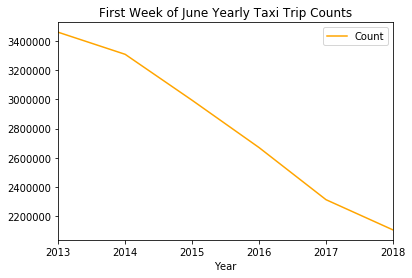

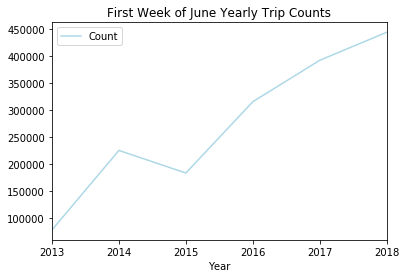

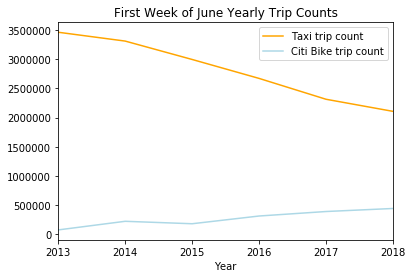

In [113]:
df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', color='lightblue') 

first_plot = df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip count'])